# Table 1 : fit Celerite results with IDL


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

First, need to merge Celerite with all ancillary catalogs for black hole mass, ansolute magnitude, redshift. 

In [56]:
# read in the results of just fitting the real LCs 
fname = '../code/190228_Celerite_real_Jeff1.npy'
r = np.load(fname).item() # it's only SDSS, SDSS-PS1 : two segments 

# convert a dict to a table, choosing relevant parts... 
seg = list(r.keys())

d1 = pd.DataFrame.from_dict(r[seg[0]])
t1 = Table.from_pandas(d1)

d2 = pd.DataFrame.from_dict(r[seg[1]])
t2 = Table.from_pandas(d2)

celerite =  join(t1,t2, keys='lcname', table_names=[seg[0] ,seg[1]])

# add a column with int  DR7  dbID  for SDSS QSO 
dbID = np.asarray([x[:-4] for x in celerite['lcname']]).astype(int)
celerite['dbID']  = dbID

# add the info about qso from DR7 catalog to have ra, dec 
#  SDSS S82  9258  DR7 QSOs from Shen+2008
# from http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dr7 = Table.read(File, format='ascii', names = colnames)
cd = join(celerite, dr7, keys='dbID')



In [58]:
cd.write('190228_Celerite_real_Jeff1_DBQSO.txt', format='ascii')

In [7]:
## add Shen2011
shen2011 = Table.read("../code/dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
m = shen2011[abs(shen2011['DEC']) < 1.5]
sel = m[['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO', 'MI_Z2' ]]

# cross-match 
cat1 = SkyCoord(ra=cd['ra']*u.degree,  dec=cd['dec']*u.degree)
cat2 = SkyCoord(ra=sel['RA']*u.degree, dec=sel['DEC']*u.degree,  frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
cd2 = hstack([cd, sel[idx]])

In [9]:
# add a column with band : here it's all r-band :
cd2['band'] = 3 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


(array([  1.,   2.,   0.,   4.,   8.,   9.,  12.,  24.,  36.,  64.,  51.,
        104.,  76.,  46.,  20.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 407.,   0., 289.,
        454., 308., 310., 330., 216., 153., 108., 150.,  76.,  62.,  41.,
          7.]),
 array([-9.71957015, -9.53333824, -9.34710633, -9.16087442, -8.97464251,
        -8.7884106 , -8.60217869, -8.41594678, -8.22971488, -8.04348297,
        -7.85725106, -7.67101915, -7.48478724, -7.29855533, -7.11232342,
        -6.92609151, -6.7398596 , -6.55362769, -6.36739578, -6.18116387,
        -5.99493196, -5.80870006, -5.62246815, -5.43623624, -5.25000433,
        -5.06377242, -4.87754051, -4.6913086 , -4.50507669, -4.31884478,
        -4.13261287, -3.94638096, -3.76014905, -3.57391714, -3.38768523,
        -3.20145333, -3.01522142, -2.82898951, -2.6427576 , -2.45652569,
        -2.27029378, -2.08406187, -1.89782996, -1.71159805, -1.52536614,
        -1.33913423]),
 <a list

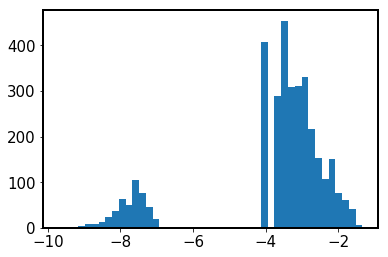

In [20]:
%matplotlib inline
# Is there much difference between Shen2008 and 2011 redshift ? 
plt.hist(np.log10(cd2['redshift']  - cd2['REDSHIFT']), 
         bins=45)
# not at all .... 

In [22]:
# add a column with restframe wavelength : lambdaRF 
lambdaobs = 6250 # for r-band, in angstroms 
cd2['lambdaRF'] = lambdaobs /  (1.+ cd2['REDSHIFT'])
    

(array([  10.,  100.,  327.,  944., 1801., 1909., 1001.,  256.,   43.,
           5.]),
 array([ 6.99691162,  7.37530811,  7.7537046 ,  8.13210109,  8.51049759,
         8.88889408,  9.26729057,  9.64568706, 10.02408355, 10.40248005,
        10.78087654]),
 <a list of 10 Patch objects>)

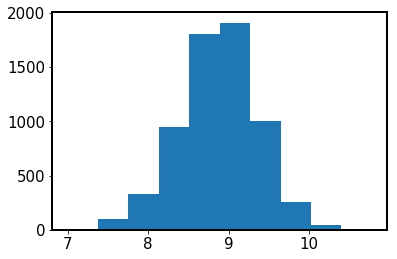

In [28]:
plt.hist(cd2['LOGBH'][cd2['LOGBH']>0])

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.1370741152764824

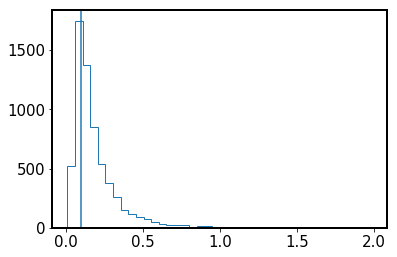

In [34]:
%matplotlib inline
plt.hist(cd2['LOGBH_ERR'][cd2['LOGBH']>0], histtype='step', bins=40)
plt.axvline(0.1)
np.median(cd2['LOGBH_ERR'][cd2['LOGBH']>0])

In [ ]:
cols = ['lcname', 'ra','dec', 'sigmaEXP_sdss', 'sigmaEXP_sdss-ps1',
        'tauEXP_sdss', 'tauEXP_sdss-ps1', 'lambdaRF', 'M_i', 'M_i_corr', 'mass_BH',
        'redshift', 'MI_Z2', 'LOGBH','LOGBH_ERR', 'REDSHIFT', 'band']
m = cd2['tauEXP_sdss-ps1'] > 5
print(np.sum(m))
cd2[cols][m].write('190228_celerite_J1_shen2007-2011.txt',
                format='ascii',overwrite='True',
                comment=False)

# Celerite : Fit for A,C (AstroML)

Note: AstroML code yields here the same results as linmix_err(), since it is the Total Least Squares problem

In [54]:
# Fit for A,C (line 4) using AstroML code .... 

# We're using only the r-band... 

# make identical declarations of variables 
# as in Chelsea's code ..
from scipy import optimize
from astroML.linear_model import TLS_logL
A = [] ;  C = [] 
band = 'r'
fit = 'EXP'
seg = 'sdss'
var = 2*cd2['sigma'+fit+'_'+seg].data ** 2.0  
# variance in mag^2, equal to sigmahat^2*tau/365 = SF_inf^2  
# SFinf = sqrt(2) * sigma,  so SFinf^2 = 2 * sigma^2 

# start with Shen2007 data : redshift, M_i_corr,  mass_BH 
redshift = cd2['redshift'].data
log10tauOBS  = np.log10(cd2['tau'+fit+'_'+seg]) # NOTE : need to shift tau to rest frame 
log10tauRF = log10tauOBS-np.log10(1.0+redshift) 
tau = log10tauRF 
lRF = cd2['lambdaRF'].data # rest-frame wavelength in Angstroms
M_i_corr = cd2['MI_Z2'].data#+0.596 # Absolute Magnitude M_i, K-corrected to z=0

select = (mass_bh > 0 ) & (cd2['tauEXP_sdss-ps1'] > 5)
print('Of ', len(select), ' quasars in that band, ',select.sum() , ' have M_BH')

x = np.log10(lRF/4000.)[select]     # Rest-wavelength array
y = (M_i_corr+23.)[select]          # Absolute Magnitude M_i, K-corrected to z=0
red = np.log10(1.+redshift)[select]  #  redshift array; not neede


# First , fit SF_inf  
f = np.log10(np.sqrt(var))[select]  

# First, remove wavelength trend: 
lampwrsf = - 0.479
fo = f - lampwrsf*x 

# Setup errors 
sigma_lum = 1e-5 #(set arbitrarily small) ; x1
sigma_y = 0.01  # uncertainty in SFinf   ; y1 

x1 = y  # luminosity 
y1 = fo # SFinf 

# Fit x1 and y1 :  
# stack the latent variables 
X = np.vstack((x1,y1)).T
dX = np.zeros((len(x1), 2, 2))
dX[:, 0, 0] = sigma_lum ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = 0 # no cross-covariance ... 

min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func, x0=[-1, 1])
print(beta_fit)
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b

slope, offset  = get_m_b(beta_fit)
print('For band ', band, 'A=', offset, 'C=', slope)


Of  6444  quasars in that band,  3248  have M_BH
Optimization terminated successfully.
         Current function value: 633640.024261
         Iterations: 102
         Function evaluations: 196
[ 0.05028082 -0.61785802]
For band  r A= -0.6219498358861202 C= 0.08137924141747081


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [55]:

#; ---------------------------
#; tau model, object-by-object:
#; ---------------------------

f = tau[select]
x = np.log10(lRF/4000.)[select]     # Rest-wavelength array
y = (M_i_corr+23.)[select]          # Absolute Magnitude M_i, K-corrected to z=0
red = np.log10(1.+redshift)[select]  #  redshift array; not needed

#; First, remove wavelength trend:
lampwrtau = 0.17
fo = f - lampwrtau*x

x1 = y # luminosity 
y1 = fo # tau 

sigma_y = 0.01  # uncertainty in tau   ; y1 

X = np.vstack((x1, y1)).T
dX = np.zeros((len(x1), 2, 2))
dX[:, 0, 0] = sigma_lum ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = 0 # no cross-covariance ... 

min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func, x0=[-1, 1])
print(beta_fit)
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b

slope, offset  = get_m_b(beta_fit)
print('For band ', band, 'A=', offset, 'C=', slope)
A.append(offset)
C.append(slope) 


Optimization terminated successfully.
         Current function value: 2674867.396936
         Iterations: 53
         Function evaluations: 103
[0.05997642 2.4831299 ]
For band  r A= 2.484578548046822 C= -0.024153556686998118
